In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

$$\newcommand{\isum}{\sum_{i}}$$
$$\newcommand{\zsum}{\sum_{k=1}^{K}}$$
$$\newcommand{\zsumi}{\sum_{\{z_i\}}}$$

## The Gaussian Mixture model using EM

We dont know how to solve for the MLE of the unsupervised problem. The EM algorithm comes to the rescue. As described above here is the algorithm:


* Repeat until convergence 
*  E-step: For each $i,j$ calculate 

$$ w_{i,j} = q_i(z_i=j)=p(z_i=j \vert  x_i, \lambda, \mu, \Sigma) $$
     
* M-step: We need to maximize, with respect to our parameters the
  
$$
\begin{eqnarray}
 \mathcal{L} &=& \sum_i \sum_{z_i} q_i(z_i) \log \frac{p(x_i,z_i  \vert \lambda, \mu, \Sigma)}{q_i(z_i)} \nonumber \\
 \mathcal{L} &=& \sum_i \sum_{j=i}^{k}  q_i(z_i=j) \log \frac{p(x_i \vert z_i=j , \mu, \Sigma) p(z_i=j \vert \lambda)}{q_i(z_i=j)} \\
 \mathcal{L} & =&  \sum_{i=1}^{m} \sum_{j=i}^{k} w_{i,j}  \log \left[   \frac{ \frac{1}{ (2\pi)^{n/2} \vert \Sigma_j \vert ^{1/2}} \exp \left(    -\frac{1}{2}(x_i-\mu_j)^T \Sigma_j^{-1} (x_i-\mu_j) \right)  \, \lambda_j   }{w_{i,j}}\right]
\end{eqnarray}
$$

Taking the derivatives yields the following updating formulas:

$$
\begin{eqnarray}
 \lambda_j &=& \frac{1}{m} \sum_{i=1}^m w_{i,j} \nonumber \\ 
 \mu_j&=& \frac{ \sum_{i=1}^m  w_{i,j} \, x_i}{ \sum_{i=1}^m  w_{i,j}} \nonumber \\ 
 \Sigma_j &=& \frac{ \sum_{i=1}^m  w_{i,j} \, (x_i-\mu_j)(x_i-\mu_j)^T}{ \sum_{i=1}^m  w_{i,j}}
\end{eqnarray}
$$

To calculate the E-step we basically calculating the posterior of the  $z$'s given the $x$'s and the
current estimate of our parameters. We can use Bayes rule 

$$ w_{i,j}= p(z_i=j \vert  x_i, \lambda, \mu, \Sigma) = \frac{p( x_i \vert  z_i=j,  \mu, \Sigma)\, p(z_i=j \vert \lambda)}{\sum_{l=1}^k p(x_i  \vert  z_i=l,  \mu, \Sigma) \, p(z_i=l \vert \lambda)} $$

Where $p(x_i  \vert  z_i =j,  \mu, \Sigma)$ is the density of the Gaussian with mean $\mu_j$ and covariance 
$\Sigma_j$ at $x_i$ and $p(z_i=j \vert  \lambda)$ is simply $\lambda_j$. 
If we to compare these formulas in the M-step with the ones we found in GDA we can see
that are very similar except that instead of using $\delta$ functions we use the $w$'s. Thus the EM algorithm corresponds here to a weighted maximum likelihood and the weights are interpreted as the 'probability' of coming from that Gaussian instead of the deterministic 
$\delta$ functions. Thus we have achived a **soft clustering** (as opposed to k-means in the unsupervised case and classification in the supervised case).

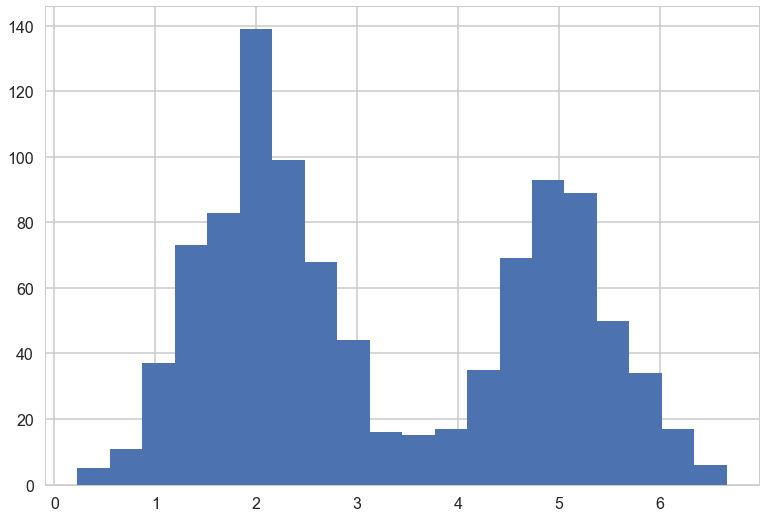

In [2]:
#In 1-D
# True parameter values
mu_true = [2, 5]
sigma_true = [0.6, 0.6]
lambda_true = .4
n = 1000

# Simulate from each distribution according to mixing proportion psi
z = np.random.binomial(1, lambda_true, n)
x = np.array([np.random.normal(mu_true[i], sigma_true[i]) for i in z])

plt.hist(x, bins=20);

In [3]:
#from Bios366 lecture notes
from scipy.stats.distributions import norm

def Estep(x, mu, sigma, lam):
    a = lam * norm.pdf(x, mu[0], sigma[0])
    b = (1. - lam) * norm.pdf(x, mu[1], sigma[1])
    return b / (a + b)



In [4]:
def Mstep(x, w):
    lam = np.mean(1.-w) 
    
    mu = [np.sum((1-w) * x)/np.sum(1-w), np.sum(w * x)/np.sum(w)]
    
    sigma = [np.sqrt(np.sum((1-w) * (x - mu[0])**2)/np.sum(1-w)), 
             np.sqrt(np.sum(w * (x - mu[1])**2)/np.sum(w))]
    
    return mu, sigma, lam

In [5]:
print(lambda_true, mu_true, sigma_true)
# Initialize values
mu = np.random.normal(4, 10, size=2)
sigma = np.random.uniform(0, 5, size=2)
lam = np.random.random()

# Stopping criterion
crit = 1e-15

# Convergence flag
converged = False

# Loop until converged
iterations=1


while not converged:
    # E-step
    if np.isnan(mu[0]) or np.isnan(mu[1]) or np.isnan(sigma[0]) or np.isnan(sigma[1]):
        print("Singularity!")
        break
        
    w = Estep(x, mu, sigma, lam)

    # M-step
    mu_new, sigma_new, lam_new = Mstep(x, w)
    
    # Check convergence
    converged = ((np.abs(lam_new - lam) < crit) 
                 & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit))
                 & np.all(np.abs((np.array(sigma_new) - np.array(sigma)) < crit)))
    mu, sigma, lam = mu_new, sigma_new, lam_new
    iterations +=1           

print("Iterations", iterations)
print('A: N({0:.4f}, {1:.4f})\nB: N({2:.4f}, {3:.4f})\nlam: {4:.4f}'.format(
                        mu_new[0], sigma_new[0], mu_new[1], sigma_new[1], lam_new))

0.4 [2, 5] [0.6, 0.6]
Iterations 85
A: N(5.0241, 0.5989)
B: N(2.0340, 0.6234)
lam: 0.4176


### Old Faithful done in sklearn

In [6]:
ofdata=pd.read_csv("data/oldfaithful.csv")
ofdata.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


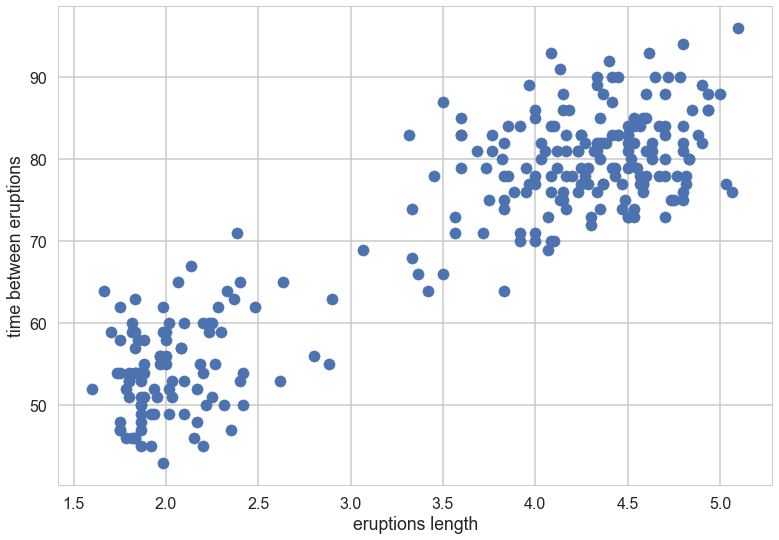

In [10]:
plt.scatter(ofdata.eruptions, ofdata.waiting);
plt.xlabel('eruptions length')
plt.ylabel('time between eruptions');

In [8]:
from sklearn import mixture
clf = mixture.GMM(n_components=2)
clf.fit(ofdata.values)

mask = clf.predict(ofdata.values)

C:\Users\Will\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Will\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Will\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Will\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function

C:\Users\Will\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


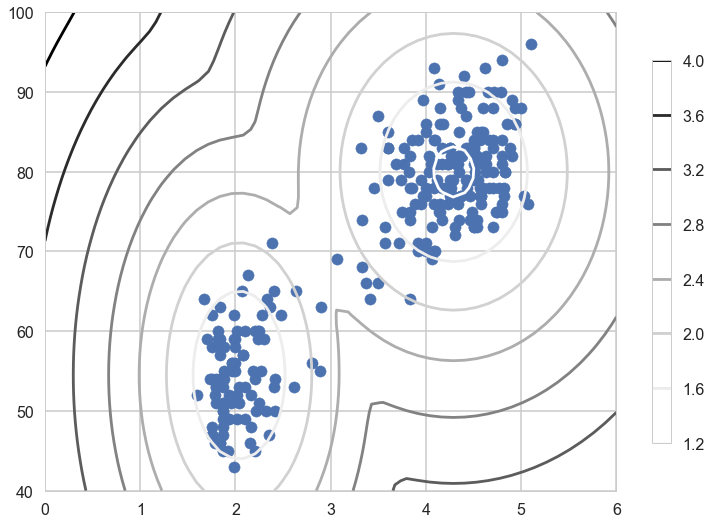

In [9]:
xx = np.linspace(0, 6) 
yy = np.linspace(40, 100) 
X, Y = np.meshgrid(xx, yy)
XX = np.c_[X.ravel(), Y.ravel()]
Z =  np.log(-clf.score_samples(XX)[0])
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z)
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(ofdata.eruptions, ofdata.waiting);